### Solving the problem for the smaller instance.

In [31]:
import gurobipy as gp
from gurobipy import GRB
import random
import time

# Problem Instance
random.seed(1234)
M = 1000  # Priority weighting for vehicle costs in the objective function.
C_L = 7   # Max locations per vehicle
locations = 15
task_count = 40

# Generate tasks with random demands and locations
tasks = [
    {'weight': random.randint(10, 30), 
     'volume': random.randint(20, 50),
     'loc': random.randint(0, locations-1)}
    for _ in range(task_count)
]

# print("Tasks:", tasks)

# Vehicle Fleet Parameters
num_large = 70
num_small = 80

# Vehicle specifications
large_vehicle_spec = {'type': 'large', 'weight_cap': 200, 'volume_cap': 300, 'cost': 350}
small_vehicle_spec = {'type': 'small', 'weight_cap': 100, 'volume_cap': 150, 'cost': 200}

# Generate vehicle fleet
vehicles = []
for i in range(num_large):
    vehicles.append(large_vehicle_spec.copy())
for i in range(num_small):
    vehicles.append(small_vehicle_spec.copy())


# Gurobi Model Formulation
with gp.Env(empty=True) as env:
    env.setParam('OutputFlag', 1)      
    env.setParam('LogToConsole', 1)    
    env.start()
    
    # Create Gurobi model
    model = gp.Model('VRP_Gurobi', env=env)
    
    # Decision Variables
    t = model.addVars(len(tasks), len(vehicles), vtype=GRB.BINARY, name="task_assign")
    o = model.addVars(len(vehicles), vtype=GRB.BINARY, name="vehicle_used")
    d = model.addVars(locations, len(vehicles), vtype=GRB.BINARY, name="location_visit")
    
    # Objective Function
    vehicle_cost = gp.quicksum(M * vehicles[r]['cost'] * o[r] for r in range(len(vehicles)))
    location_cost = gp.quicksum(d[l, r] for l in range(locations) for r in range(len(vehicles)))
    model.setObjective(vehicle_cost + location_cost, GRB.MINIMIZE)
    
    # Constraints
    for i in range(len(tasks)):
        model.addConstr(
            gp.quicksum(t[i, r] for r in range(len(vehicles))) == 1,
            name=f"task_assignment_{i}"
        )
    
    for r in range(len(vehicles)):
        model.addConstr(
            gp.quicksum(tasks[i]['weight'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['weight_cap'],
            name=f"weight_capacity_{r}"
        )
        model.addConstr(
            gp.quicksum(tasks[i]['volume'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['volume_cap'],
            name=f"volume_capacity_{r}"
        )
        model.addConstr(
            gp.quicksum(d[l, r] for l in range(locations)) <= C_L * o[r],
            name=f"location_limit_{r}"
        )
        model.addConstr(
            gp.quicksum(t[i, r] for i in range(len(tasks))) <= len(tasks) * o[r],
            name=f"vehicle_usage_{r}"
        )
    
    for l in range(locations):
        for r in range(len(vehicles)):
            model.addConstr(
                gp.quicksum(t[i, r] for i in range(len(tasks)) if tasks[i]['loc'] == l) <= len(tasks) * d[l, r],
                name=f"location_visit_{l}_{r}"
            )
    
    
    # Solve Model with timing
    start_time = time.time()
    model.optimize()
    end_time = time.time()
    solve_time = end_time - start_time


    # Solution Extraction and Output

    if model.Status == GRB.OPTIMAL or model.Status == GRB.SUBOPTIMAL:
        print(f"\nSolve Time: {solve_time:.2f} seconds")
        print(f"Optimal Objective Value: {model.ObjVal}")
        used_vehicles = [r for r in range(len(vehicles)) if o[r].X > 0.5]
        print(f"Vehicles Used: {len(used_vehicles)}")
        solution = {r: {'tasks': [], 'locations': set()} for r in used_vehicles}
        for i in range(len(tasks)):
            for r in used_vehicles:
                if t[i, r].X > 0.5:
                    solution[r]['tasks'].append(i)
                    solution[r]['locations'].add(tasks[i]['loc'])
        for r in used_vehicles:
            vehicle_type = "large" if r < num_large else "small"
            print(f"\nVehicle {r} ({vehicle_type}):")
            print(f"- Tasks: {sorted(solution[r]['tasks'])}")
            print(f"- Locations: {sorted(solution[r]['locations'])}")
            print(f"- Weight Used: {sum(tasks[i]['weight'] for i in solution[r]['tasks'])}/{vehicles[r]['weight_cap']}")
            print(f"- Volume Used: {sum(tasks[i]['volume'] for i in solution[r]['tasks'])}/{vehicles[r]['volume_cap']}")
        # Location constraint check
        print(f"\nLocation Visit Verification (Max allowed: {C_L}):")
        for r in used_vehicles:
            vehicle_type = "large" if r < num_large else "small"
            locations_visited = len(solution[r]['locations'])
            status = "" if locations_visited <= C_L else "VIOLATION"
            print(f"- Vehicle {r} ({vehicle_type}): {locations_visited} locations {status}")
    elif model.Status == GRB.INFEASIBLE:
        print("Model is infeasible!")
        model.computeIIS()
        model.write("infeasible_model.ilp")
    else:
        print(f"Optimization ended with status: {model.Status}")


Set parameter Username
Set parameter LicenseID to value 2616800
Academic license - for non-commercial use only - expires 2026-01-31
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2890 rows, 8400 columns and 34800 nonzeros
Model fingerprint: 0x276c09ae
Variable types: 0 continuous, 8400 integer (8400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 8800038.0000
Presolve removed 900 rows and 900 columns
Presolve time: 0.15s
Presolved: 1990 rows, 7500 columns, 33000 nonzeros
Variable types: 0 continuous, 7500 integer (7500 binary)

Root relaxation: objective 1.076936e+06, 9281 iterations, 0.31 seconds (0.20 work units)



###  Plot of tightness of packing to Location Limit


 Iteration for C_L = 1

 Optimal Objective Value: 2000010.0
Vehicles Used: 10

Vehicle 20 (small):
- Tasks: [26]
- Locations: [6]
- Weight Used: 19/100 (19.00%)
- Volume Used: 6/150 (4.00%)

Vehicle 22 (small):
- Tasks: [1, 11, 21]
- Locations: [9]
- Weight Used: 30/100 (30.00%)
- Volume Used: 21/150 (14.00%)

Vehicle 25 (small):
- Tasks: [3, 5]
- Locations: [5]
- Weight Used: 38/100 (38.00%)
- Volume Used: 34/150 (22.67%)

Vehicle 27 (small):
- Tasks: [13, 14, 15, 25]
- Locations: [4]
- Weight Used: 86/100 (86.00%)
- Volume Used: 38/150 (25.33%)

Vehicle 31 (small):
- Tasks: [7, 20, 23, 28]
- Locations: [2]
- Weight Used: 82/100 (82.00%)
- Volume Used: 60/150 (40.00%)

Vehicle 34 (small):
- Tasks: [4, 17, 18, 27]
- Locations: [0]
- Weight Used: 65/100 (65.00%)
- Volume Used: 59/150 (39.33%)

Vehicle 35 (small):
- Tasks: [16]
- Locations: [3]
- Weight Used: 12/100 (12.00%)
- Volume Used: 25/150 (16.67%)

Vehicle 37 (small):
- Tasks: [0, 2, 8, 22, 24]
- Locations: [1]
- Weight Used: 67

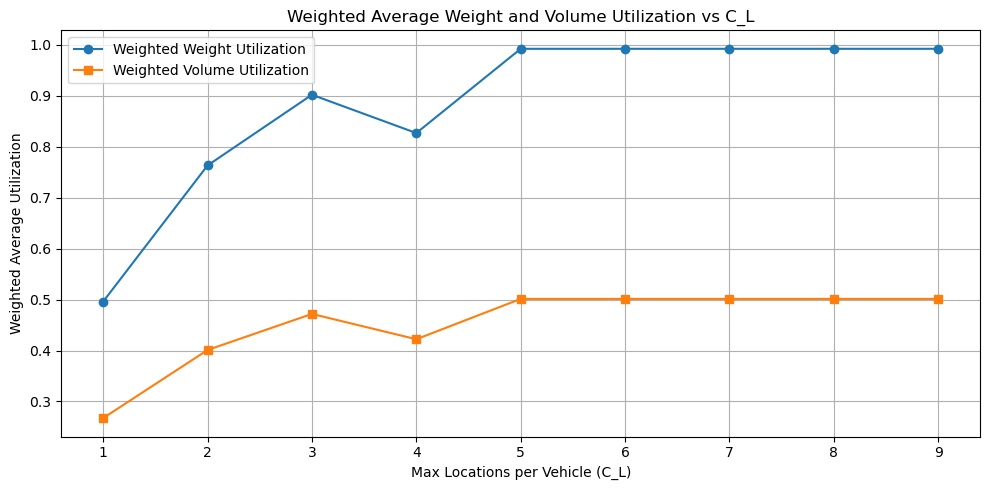

In [32]:
import gurobipy as gp
from gurobipy import GRB
import random
import matplotlib.pyplot as plt

random.seed(1234)

# Constant parameters
M = 1000
locations = 10
task_count = 30
num_large = 20
num_small = 20

# Generate tasks
tasks = [
    {'weight': random.randint(5, 30),
     'volume': random.randint(5, 30),
     'loc': random.randint(0, locations-1)}
    for _ in range(task_count)
]

# Define vehicles
large_vehicle_spec = {'type': 'large', 'weight_cap': 250, 'volume_cap': 400, 'cost': 350}
small_vehicle_spec = {'type': 'small', 'weight_cap': 100, 'volume_cap': 150, 'cost': 200}
vehicles = [large_vehicle_spec.copy() for _ in range(num_large)] + [small_vehicle_spec.copy() for _ in range(num_small)]
C_L_values = []
vehicles_used_list = []
avg_weight_util_list = []
avg_volume_util_list = []

# Iterate over C_L from 1 to 9
for C_L in range(1, 10):
    print("\n" + "="*50)
    print(f" Iteration for C_L = {C_L}")
    print("="*50)

    with gp.Env(empty=True) as env:
        env.setParam('OutputFlag', 0)
        env.setParam('LogToConsole', 0)
        env.start()

        model = gp.Model('VRP_Gurobi', env=env)
        t = model.addVars(len(tasks), len(vehicles), vtype=GRB.BINARY, name="task_assign")
        o = model.addVars(len(vehicles), vtype=GRB.BINARY, name="vehicle_used")
        d = model.addVars(locations, len(vehicles), vtype=GRB.BINARY, name="location_visit")

        vehicle_cost = gp.quicksum(M * vehicles[r]['cost'] * o[r] for r in range(len(vehicles)))
        location_cost = gp.quicksum(d[l, r] for l in range(locations) for r in range(len(vehicles)))
        model.setObjective(vehicle_cost + location_cost, GRB.MINIMIZE)

        for i in range(len(tasks)):
            model.addConstr(gp.quicksum(t[i, r] for r in range(len(vehicles))) == 1)

        for r in range(len(vehicles)):
            model.addConstr(gp.quicksum(tasks[i]['weight'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['weight_cap'])
            model.addConstr(gp.quicksum(tasks[i]['volume'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['volume_cap'])
            model.addConstr(gp.quicksum(d[l, r] for l in range(locations)) <= C_L * o[r])
            model.addConstr(gp.quicksum(t[i, r] for i in range(len(tasks))) <= len(tasks) * o[r])

        for l in range(locations):
            for r in range(len(vehicles)):
                model.addConstr(gp.quicksum(t[i, r] for i in range(len(tasks)) if tasks[i]['loc'] == l) <= len(tasks) * d[l, r])

        
    

        model.optimize()

        if model.Status == GRB.OPTIMAL or model.Status == GRB.SUBOPTIMAL:
            print(f"\n Optimal Objective Value: {model.ObjVal}")
            used_vehicles = [r for r in range(len(vehicles)) if o[r].X > 0.5]
            print(f"Vehicles Used: {len(used_vehicles)}")

            solution = {r: {'tasks': [], 'locations': set()} for r in used_vehicles}

            # Initialize totals for weighted average
            total_weight_used = 0.0
            total_weight_capacity = 0.0
            total_volume_used = 0.0
            total_volume_capacity = 0.0

            for i in range(len(tasks)):
                for r in used_vehicles:
                    if t[i, r].X > 0.5:
                        solution[r]['tasks'].append(i)
                        solution[r]['locations'].add(tasks[i]['loc'])

            for r in used_vehicles:
                tasks_r = solution[r]['tasks']
                locs_r = sorted(solution[r]['locations'])
                weight_used = sum(tasks[i]['weight'] for i in tasks_r)
                volume_used = sum(tasks[i]['volume'] for i in tasks_r)
                weight_cap = vehicles[r]['weight_cap']
                volume_cap = vehicles[r]['volume_cap']
                weight_util = weight_used / weight_cap
                volume_util = volume_used / volume_cap
                vehicle_type = "large" if r < num_large else "small"

                print(f"\nVehicle {r} ({vehicle_type}):")
                print(f"- Tasks: {sorted(tasks_r)}")
                print(f"- Locations: {locs_r}")
                print(f"- Weight Used: {weight_used}/{weight_cap} ({weight_util:.2%})")
                print(f"- Volume Used: {volume_used}/{volume_cap} ({volume_util:.2%})")

                # weighted average
                total_weight_used += weight_used
                total_weight_capacity += weight_cap
                total_volume_used += volume_used
                total_volume_capacity += volume_cap

            print(f"\n Location Visit Verification (Max allowed: {C_L}):")
            for r in used_vehicles:
                locs = len(solution[r]['locations'])
                status = "" if locs <= C_L else " VIOLATION"
                vehicle_type = "large" if r < num_large else "small"
                print(f"- Vehicle {r} ({vehicle_type}): {locs} locations {status}")

            # Weighted average utilisation
            if total_weight_capacity > 0:
                avg_weight_util = total_weight_used / total_weight_capacity
            else:
                avg_weight_util = 0.0
            if total_volume_capacity > 0:
                avg_volume_util = total_volume_used / total_volume_capacity
            else:
                avg_volume_util = 0.0

            print(f"\n Weighted Average Weight Utilization: {avg_weight_util:.2%}")
            print(f" Weighted Average Volume Utilization: {avg_volume_util:.2%}")

        
            C_L_values.append(C_L)
            vehicles_used_list.append(len(used_vehicles))
            avg_weight_util_list.append(avg_weight_util)
            avg_volume_util_list.append(avg_volume_util)

        elif model.Status == GRB.INFEASIBLE:
            print(" Model is infeasible!")
        else:
            print(f"Optimization ended with status: {model.Status}")

# Plotting results
plt.figure(figsize=(10, 5))
plt.plot(C_L_values, avg_weight_util_list, marker='o', label='Weighted Weight Utilization')
plt.plot(C_L_values, avg_volume_util_list, marker='s', label='Weighted Volume Utilization')
plt.xlabel('Max Locations per Vehicle (C_L)')
plt.ylabel('Weighted Average Utilization')
plt.title('Weighted Average Weight and Volume Utilization vs C_L')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Plot Cost to the location limit.

Set parameter Username
Set parameter LicenseID to value 2616800
Academic license - for non-commercial use only - expires 2026-01-31
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1450 rows, 6100 columns and 27200 nonzeros
Model fingerprint: 0x609b70b9
Variable types: 0 continuous, 6100 integer (6100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Found heuristic solution: objective 1.185005e+07
Presolve removed 100 rows and 0 columns
Presolve time: 0.03s
Presolved: 1350 rows, 6100 columns, 22200 nonzeros
Variable types: 0 continuous, 6100 integer (6100 binary)

Root relaxation: objective 3.333433e+05, 3224 iterations, 0.04 seconds (0.05 work units)

  

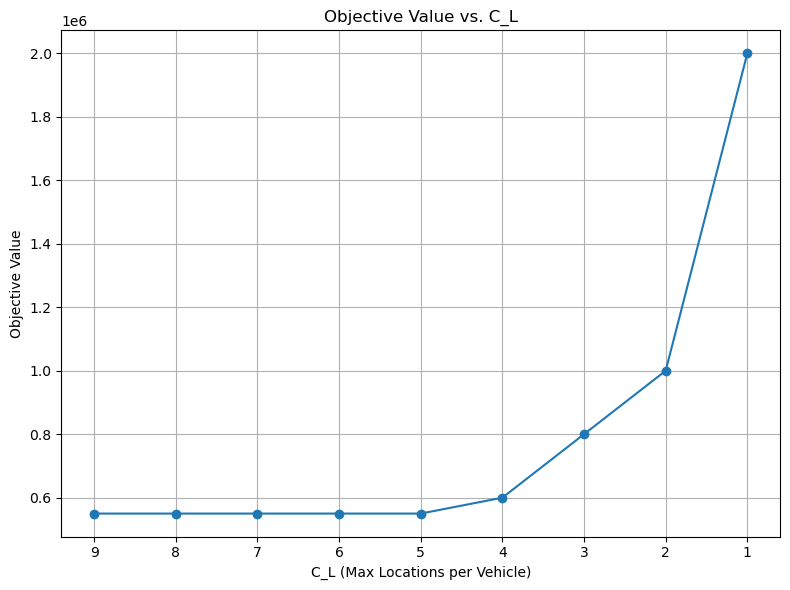

[550010.0, 550010.0, 550012.0, 550010.0, 550010.0, 600010.0, 800010.0, 1000010.0, 2000010.0]


In [33]:
import gurobipy as gp
from gurobipy import GRB
import random
import matplotlib.pyplot as plt

# Problem Instance
random.seed(1234)
M = 1000  # Priority weighting for vehicle costs
locations = 10
task_count = 50

# Generate tasks with random demands and locations
tasks = [
    {'weight': random.randint(1, 10),
     'volume': random.randint(1, 10),
     'loc': random.randint(0, locations - 1)}
    for _ in range(task_count)
]

# Vehicle Fleet Parameters
num_large = 50
num_small = 50

# Vehicle specifications
large_vehicle_spec = {'type': 'large', 'weight_cap': 400, 'volume_cap': 400, 'cost': 350}
small_vehicle_spec = {'type': 'small', 'weight_cap': 100, 'volume_cap': 150, 'cost': 200}

# Generate vehicle fleet
vehicles = [large_vehicle_spec.copy() for _ in range(num_large)] + \
           [small_vehicle_spec.copy() for _ in range(num_small)]

# Results storage
cl_values = list(range(9, 0, -1))
objective_values = []

# Gurobi Silent Environment
with gp.Env(empty=True) as env:
    env.setParam('OutputFlag', 1)      # Set to 0 for silent mode
    env.start()

    for C_L in cl_values:
        model = gp.Model('VRP_Gurobi', env=env)

        # Decision Variables
        t = model.addVars(len(tasks), len(vehicles), vtype=GRB.BINARY, name="task_assign")
        o = model.addVars(len(vehicles), vtype=GRB.BINARY, name="vehicle_used")
        d = model.addVars(locations, len(vehicles), vtype=GRB.BINARY, name="location_visit")

        # Objective Function
        vehicle_cost = gp.quicksum(M * vehicles[r]['cost'] * o[r] for r in range(len(vehicles)))
        location_cost = gp.quicksum(d[l, r] for l in range(locations) for r in range(len(vehicles)))
        model.setObjective(vehicle_cost + location_cost, GRB.MINIMIZE)

        # Constraints
        for i in range(len(tasks)):
            model.addConstr(gp.quicksum(t[i, r] for r in range(len(vehicles))) == 1)

        for r in range(len(vehicles)):
            model.addConstr(gp.quicksum(tasks[i]['weight'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['weight_cap'])
            model.addConstr(gp.quicksum(tasks[i]['volume'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['volume_cap'])
            model.addConstr(gp.quicksum(d[l, r] for l in range(locations)) <= C_L * o[r])
            model.addConstr(gp.quicksum(t[i, r] for i in range(len(tasks))) <= len(tasks) * o[r])

        for l in range(locations):
            for r in range(len(vehicles)):
                model.addConstr(gp.quicksum(t[i, r] for i in range(len(tasks)) if tasks[i]['loc'] == l) <= len(tasks) * d[l, r])

        

        # Solve
        model.optimize()

        # Collect and print solution details
        if model.Status == GRB.OPTIMAL or model.Status == GRB.SUBOPTIMAL:
            objective_values.append(model.ObjVal)
            print(f"\n--- C_L = {C_L} ---")
            print(f"Objective Value: {model.ObjVal}")

            used_vehicles = [r for r in range(len(vehicles)) if o[r].X > 0.5]
            print(f"Vehicles Used: {len(used_vehicles)}")

            solution = {r: {'tasks': [], 'locations': set()} for r in used_vehicles}
            for i in range(len(tasks)):
                for r in used_vehicles:
                    if t[i, r].X > 0.5:
                        solution[r]['tasks'].append(i)
                        solution[r]['locations'].add(tasks[i]['loc'])

            for r in used_vehicles:
                vehicle_type = "large" if r < num_large else "small"
                print(f"\nVehicle {r} ({vehicle_type}):")
                print(f"- Tasks: {sorted(solution[r]['tasks'])}")
                print(f"- Locations: {sorted(solution[r]['locations'])}")
                print(f"- Weight Used: {sum(tasks[i]['weight'] for i in solution[r]['tasks'])}/{vehicles[r]['weight_cap']}")
                print(f"- Volume Used: {sum(tasks[i]['volume'] for i in solution[r]['tasks'])}/{vehicles[r]['volume_cap']}")

            print(f"\nLocation Visit Verification (Max allowed: {C_L}):")
            for r in used_vehicles:
                vehicle_type = "large" if r < num_large else "small"
                locations_visited = len(solution[r]['locations'])
                status = "" if locations_visited <= C_L else "VIOLATION"
                print(f"- Vehicle {r} ({vehicle_type}): {locations_visited} locations {status}")
        else:
            objective_values.append(None)  

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(cl_values, objective_values, marker='o')
plt.xlabel("C_L (Max Locations per Vehicle)")
plt.ylabel("Objective Value")
plt.title("Objective Value vs. C_L")
plt.grid(True)
plt.gca().invert_xaxis() 
plt.tight_layout()
plt.show()
print(objective_values)


### Solving a problem instace with 10 locations and each location have 3 tasks the weight capacity of each even location is equal to the carrying capcity of small type vehicle and similarly each odd location  has 3 tasks with weight capacity of Large  vehicle. the location limit is set to be 1.

####  It uses the 10 vehicles, 5 large  vehicles visiting odd locations and small type vehicles on even locations.

In [34]:
import gurobipy as gp
from gurobipy import GRB
import random
import time

# Problem Instance
random.seed(1234)
M = 1000  # Priority weight
C_L = 1   # Max locations per vehicle
locations = 10
tasks_per_location = 3
task_count = locations * tasks_per_location

# Vehicles type
large_vehicle_spec = {'type': 'large', 'weight_cap': 200, 'volume_cap': 300, 'cost': 350}
small_vehicle_spec = {'type': 'small', 'weight_cap': 100, 'volume_cap': 150, 'cost': 200}


def random_partition(total, n):
    cuts = sorted(random.sample(range(1, total), n-1))
    return [a - b for a, b in zip(cuts + [total], [0] + cuts)]

# Generate tasks with structured demands and locations
tasks = []
for loc in range(locations):
    if loc % 2 == 1:  # Odd location: large vehicle
        w_total, v_total = large_vehicle_spec['weight_cap'], large_vehicle_spec['volume_cap']
    else:             # Even location: small vehicle
        w_total, v_total = small_vehicle_spec['weight_cap'], small_vehicle_spec['volume_cap']
    weights = random_partition(w_total, tasks_per_location)
    volumes = random_partition(v_total, tasks_per_location)
    for i in range(tasks_per_location):
        tasks.append({'weight': weights[i], 'volume': volumes[i], 'loc': loc})

# Vehicle Fleet Parameters
num_large = 10
num_small = 10

# Generate vehicle fleet
vehicles = []
for i in range(num_large):
    vehicles.append(large_vehicle_spec.copy())
for i in range(num_small):
    vehicles.append(small_vehicle_spec.copy())


# Gurobi Model Formulation

with gp.Env(empty=True) as env:
    env.setParam('OutputFlag', 1)      
    env.setParam('LogToConsole', 1)    
    env.start()
    
    # Create Gurobi model
    model = gp.Model('VRP_Gurobi', env=env)
    
    # Decision Variables
    t = model.addVars(len(tasks), len(vehicles), vtype=GRB.BINARY, name="task_assign")
    o = model.addVars(len(vehicles), vtype=GRB.BINARY, name="vehicle_used")
    d = model.addVars(locations, len(vehicles), vtype=GRB.BINARY, name="location_visit")
    
    # Objective Function
    vehicle_cost = gp.quicksum(M * vehicles[r]['cost'] * o[r] for r in range(len(vehicles)))
    location_cost = gp.quicksum(d[l, r] for l in range(locations) for r in range(len(vehicles)))
    model.setObjective(vehicle_cost + location_cost, GRB.MINIMIZE)
    
    # Constraints
    for i in range(len(tasks)):
        model.addConstr(
            gp.quicksum(t[i, r] for r in range(len(vehicles))) == 1,
            name=f"task_assignment_{i}"
        )
    
    for r in range(len(vehicles)):
        model.addConstr(
            gp.quicksum(tasks[i]['weight'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['weight_cap'],
            name=f"weight_capacity_{r}"
        )
        model.addConstr(
            gp.quicksum(tasks[i]['volume'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['volume_cap'],
            name=f"volume_capacity_{r}"
        )
        model.addConstr(
            gp.quicksum(d[l, r] for l in range(locations)) <= C_L * o[r],
            name=f"location_limit_{r}"
        )
        model.addConstr(
            gp.quicksum(t[i, r] for i in range(len(tasks))) <= len(tasks) * o[r],
            name=f"vehicle_usage_{r}"
        )
    
    for l in range(locations):
        for r in range(len(vehicles)):
            model.addConstr(
                gp.quicksum(t[i, r] for i in range(len(tasks)) if tasks[i]['loc'] == l) <= len(tasks) * d[l, r],
                name=f"location_visit_{l}_{r}"
            )
    
    start_time = time.time()
    model.optimize()
    end_time = time.time()
    solve_time = end_time - start_time

    # Solution Extraction and Output
    if model.Status == GRB.OPTIMAL or model.Status == GRB.SUBOPTIMAL:
        print(f"\nSolve Time: {solve_time:.2f} seconds")
        print(f"Optimal Objective Value: {model.ObjVal}")
        used_vehicles = [r for r in range(len(vehicles)) if o[r].X > 0.5]
        print(f"Vehicles Used: {len(used_vehicles)}")
        solution = {r: {'tasks': [], 'locations': set()} for r in used_vehicles}
        for i in range(len(tasks)):
            for r in used_vehicles:
                if t[i, r].X > 0.5:
                    solution[r]['tasks'].append(i)
                    solution[r]['locations'].add(tasks[i]['loc'])
        for r in used_vehicles:
            vehicle_type = "large" if r < num_large else "small"
            print(f"\nVehicle {r} ({vehicle_type}):")
            print(f"- Tasks: {sorted(solution[r]['tasks'])}")
            print(f"- Locations: {sorted(solution[r]['locations'])}")
            print(f"- Weight Used: {sum(tasks[i]['weight'] for i in solution[r]['tasks'])}/{vehicles[r]['weight_cap']}")
            print(f"- Volume Used: {sum(tasks[i]['volume'] for i in solution[r]['tasks'])}/{vehicles[r]['volume_cap']}")
        # Location constraint check
        print(f"\nLocation Visit Verification (Max allowed: {C_L}):")
        for r in used_vehicles:
            vehicle_type = "large" if r < num_large else "small"
            locations_visited = len(solution[r]['locations'])
            status = "" if locations_visited <= C_L else "VIOLATION"
            print(f"- Vehicle {r} ({vehicle_type}): {locations_visited} locations {status}")
    elif model.Status == GRB.INFEASIBLE:
        print("Model is infeasible!")
        model.computeIIS()
        model.write("infeasible_model.ilp")
    else:
        print(f"Optimization ended with status: {model.Status}")


Set parameter Username
Set parameter LicenseID to value 2616800
Academic license - for non-commercial use only - expires 2026-01-31
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 310 rows, 820 columns and 3440 nonzeros
Model fingerprint: 0x6c31c5df
Variable types: 0 continuous, 820 integer (820 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [1e+00, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 5500020.0000
Presolve removed 50 rows and 140 columns
Presolve time: 0.01s
Presolved: 260 rows, 680 columns, 2890 nonzeros
Variable types: 0 continuous, 680 integer (680 binary)

Root relaxation: objective 2.750010e+06, 627 iterations, 0.01 seconds (0.01 work units)

    Nodes   

### To the above data we increse the location limit to 4.

In [35]:
import gurobipy as gp
from gurobipy import GRB
import random
import time

# Problem Instance
random.seed(1234)
M = 1000  # Priority weighs
C_L = 4  # Max locations per vehicle
locations = 10
tasks_per_location = 3
task_count = locations * tasks_per_location

# Vehicle type
large_vehicle_spec = {'type': 'large', 'weight_cap': 200, 'volume_cap': 300, 'cost': 350}
small_vehicle_spec = {'type': 'small', 'weight_cap': 100, 'volume_cap': 150, 'cost': 200}

def random_partition(total, n):
    cuts = sorted(random.sample(range(1, total), n-1))
    return [a - b for a, b in zip(cuts + [total], [0] + cuts)]

# Generate tasks with structured demands and locations
tasks = []
for loc in range(locations):
    if loc % 2 == 1:  # Odd location: large vehicle
        w_total, v_total = large_vehicle_spec['weight_cap'], large_vehicle_spec['volume_cap']
    else:             # Even location: small vehicle
        w_total, v_total = small_vehicle_spec['weight_cap'], small_vehicle_spec['volume_cap']
    weights = random_partition(w_total, tasks_per_location)
    volumes = random_partition(v_total, tasks_per_location)
    for i in range(tasks_per_location):
        tasks.append({'weight': weights[i], 'volume': volumes[i], 'loc': loc})

# Vehicle Fleet Parameters
num_large = 10
num_small = 10

# Generate vehicle fleet
vehicles = []
for i in range(num_large):
    vehicles.append(large_vehicle_spec.copy())
for i in range(num_small):
    vehicles.append(small_vehicle_spec.copy())


# Gurobi Model Formulation

with gp.Env(empty=True) as env:
    env.setParam('OutputFlag', 1)      
    env.setParam('LogToConsole', 1) 
    env.start()
    
    # Create Gurobi model
    model = gp.Model('VRP_Gurobi', env=env)
    
    # Decision Variables
    t = model.addVars(len(tasks), len(vehicles), vtype=GRB.BINARY, name="task_assign")
    o = model.addVars(len(vehicles), vtype=GRB.BINARY, name="vehicle_used")
    d = model.addVars(locations, len(vehicles), vtype=GRB.BINARY, name="location_visit")
    
    # Objective Function
    vehicle_cost = gp.quicksum(M * vehicles[r]['cost'] * o[r] for r in range(len(vehicles)))
    location_cost = gp.quicksum(d[l, r] for l in range(locations) for r in range(len(vehicles)))
    model.setObjective(vehicle_cost + location_cost, GRB.MINIMIZE)
    
    # Constraints
    for i in range(len(tasks)):
        model.addConstr(
            gp.quicksum(t[i, r] for r in range(len(vehicles))) == 1,
            name=f"task_assignment_{i}"
        )
    
    for r in range(len(vehicles)):
        model.addConstr(
            gp.quicksum(tasks[i]['weight'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['weight_cap'],
            name=f"weight_capacity_{r}"
        )
        model.addConstr(
            gp.quicksum(tasks[i]['volume'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['volume_cap'],
            name=f"volume_capacity_{r}"
        )
        model.addConstr(
            gp.quicksum(d[l, r] for l in range(locations)) <= C_L * o[r],
            name=f"location_limit_{r}"
        )
        model.addConstr(
            gp.quicksum(t[i, r] for i in range(len(tasks))) <= len(tasks) * o[r],
            name=f"vehicle_usage_{r}"
        )
    
    for l in range(locations):
        for r in range(len(vehicles)):
            model.addConstr(
                gp.quicksum(t[i, r] for i in range(len(tasks)) if tasks[i]['loc'] == l) <= len(tasks) * d[l, r],
                name=f"location_visit_{l}_{r}"
            )
    
    # Solve Model with timing
    start_time = time.time()
    model.optimize()
    end_time = time.time()
    solve_time = end_time - start_time

    # Solution Extraction and Output
    if model.Status == GRB.OPTIMAL or model.Status == GRB.SUBOPTIMAL:
        print(f"\nSolve Time: {solve_time:.2f} seconds")
        print(f"Optimal Objective Value: {model.ObjVal}")
        used_vehicles = [r for r in range(len(vehicles)) if o[r].X > 0.5]
        print(f"Vehicles Used: {len(used_vehicles)}")
        solution = {r: {'tasks': [], 'locations': set()} for r in used_vehicles}
        for i in range(len(tasks)):
            for r in used_vehicles:
                if t[i, r].X > 0.5:
                    solution[r]['tasks'].append(i)
                    solution[r]['locations'].add(tasks[i]['loc'])
        for r in used_vehicles:
            vehicle_type = "large" if r < num_large else "small"
            print(f"\nVehicle {r} ({vehicle_type}):")
            print(f"- Tasks: {sorted(solution[r]['tasks'])}")
            print(f"- Locations: {sorted(solution[r]['locations'])}")
            print(f"- Weight Used: {sum(tasks[i]['weight'] for i in solution[r]['tasks'])}/{vehicles[r]['weight_cap']}")
            print(f"- Volume Used: {sum(tasks[i]['volume'] for i in solution[r]['tasks'])}/{vehicles[r]['volume_cap']}")
        # Location constraint check
        print(f"\nLocation Visit Verification (Max allowed: {C_L}):")
        for r in used_vehicles:
            vehicle_type = "large" if r < num_large else "small"
            locations_visited = len(solution[r]['locations'])
            status = "" if locations_visited <= C_L else "VIOLATION"
            print(f"- Vehicle {r} ({vehicle_type}): {locations_visited} locations {status}")
    elif model.Status == GRB.INFEASIBLE:
        print("Model is infeasible!")
        model.computeIIS()
        model.write("infeasible_model.ilp")
    else:
        print(f"Optimization ended with status: {model.Status}")


Set parameter Username
Set parameter LicenseID to value 2616800
Academic license - for non-commercial use only - expires 2026-01-31
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 310 rows, 820 columns and 3440 nonzeros
Model fingerprint: 0x2eb8ce28
Variable types: 0 continuous, 820 integer (820 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [1e+00, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 4700026.0000
Presolve removed 40 rows and 130 columns
Presolve time: 0.01s
Presolved: 270 rows, 690 columns, 2910 nonzeros
Variable types: 0 continuous, 690 integer (690 binary)

Root relaxation: objective 7.500120e+05, 1366 iterations, 0.00 seconds (0.01 work units)

    Nodes  

### In the above problem instance we swap the tasks among locations.

In [1]:
import gurobipy as gp
from gurobipy import GRB
import random
import time

#  Problem Parameters
random.seed(1234)
M = 1000  # Priority weighting for vehicle costs
C_L = 3   # Max locations per vehicle
locations = 10
tasks_per_location = 3
task_count = locations * tasks_per_location

# Vehicle specifications
large_vehicle_spec = {'type': 'large', 'weight_cap': 200, 'volume_cap': 300, 'cost': 350}
small_vehicle_spec = {'type': 'small', 'weight_cap': 100, 'volume_cap': 150, 'cost': 200}

# ---- 2. Structured Task Generation ----
def random_partition(total, n):
    """Randomly partition 'total' into 'n' positive integers."""
    cuts = sorted(random.sample(range(1, total), n-1))
    return [a - b for a, b in zip(cuts + [total], [0] + cuts)]

tasks = []
for loc in range(locations):
    if loc % 2 == 1:  # Odd location: large vehicle
        w_total, v_total = large_vehicle_spec['weight_cap'], large_vehicle_spec['volume_cap']
    else:             # Even location: small vehicle
        w_total, v_total = small_vehicle_spec['weight_cap'], small_vehicle_spec['volume_cap']
    weights = random_partition(w_total, tasks_per_location)
    volumes = random_partition(v_total, tasks_per_location)
    for i in range(tasks_per_location):
        tasks.append({'weight': weights[i], 'volume': volumes[i], 'loc': loc})

print("Before swaps:")
for loc in range(locations):
    print(f"Location {loc}: {[t for t in tasks if t['loc'] == loc]}")

#  Random Swaps Between Locations
def swap_tasks_between_locations(tasks, num_swaps):
    n = len(tasks)
    swaps_done = 0
    attempts = 0
    while swaps_done < num_swaps and attempts < num_swaps * 10:
        idx1, idx2 = random.sample(range(n), 2)
        if tasks[idx1]['loc'] != tasks[idx2]['loc']:
            tasks[idx1]['loc'], tasks[idx2]['loc'] = tasks[idx2]['loc'], tasks[idx1]['loc']
            swaps_done += 1
        attempts += 1

swap_tasks_between_locations(tasks, num_swaps=15)

print("\nAfter swaps:")
for loc in range(locations):
    print(f"Location {loc}: {[t for t in tasks if t['loc'] == loc]}")

#  Vehicle Fleet Generation
num_large = 10
num_small = 10
vehicles = []
for i in range(num_large):
    vehicles.append(large_vehicle_spec.copy())
for i in range(num_small):
    vehicles.append(small_vehicle_spec.copy())

# Gurobi Model Formulation
with gp.Env(empty=True) as env:
    env.setParam('OutputFlag', 1)
    env.setParam('LogToConsole', 1)
    env.start()
    
    model = gp.Model('VRP_Gurobi', env=env)
    
    t = model.addVars(len(tasks), len(vehicles), vtype=GRB.BINARY, name="task_assign")
    o = model.addVars(len(vehicles), vtype=GRB.BINARY, name="vehicle_used")
    d = model.addVars(locations, len(vehicles), vtype=GRB.BINARY, name="location_visit")
    
    vehicle_cost = gp.quicksum(M * vehicles[r]['cost'] * o[r] for r in range(len(vehicles)))
    location_cost = gp.quicksum(d[l, r] for l in range(locations) for r in range(len(vehicles)))
    model.setObjective(vehicle_cost + location_cost, GRB.MINIMIZE)
    
    for i in range(len(tasks)):
        model.addConstr(
            gp.quicksum(t[i, r] for r in range(len(vehicles))) == 1,
            name=f"task_assignment_{i}"
        )
    
    for r in range(len(vehicles)):
        model.addConstr(
            gp.quicksum(tasks[i]['weight'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['weight_cap'],
            name=f"weight_capacity_{r}"
        )
        model.addConstr(
            gp.quicksum(tasks[i]['volume'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['volume_cap'],
            name=f"volume_capacity_{r}"
        )
        model.addConstr(
            gp.quicksum(d[l, r] for l in range(locations)) <= C_L * o[r],
            name=f"location_limit_{r}"
        )
        model.addConstr(
            gp.quicksum(t[i, r] for i in range(len(tasks))) <= len(tasks) * o[r],
            name=f"vehicle_usage_{r}"
        )
    
    for l in range(locations):
        for r in range(len(vehicles)):
            model.addConstr(
                gp.quicksum(t[i, r] for i in range(len(tasks)) if tasks[i]['loc'] == l) <= len(tasks) * d[l, r],
                name=f"location_visit_{l}_{r}"
            )
    
    #  Solve Model
    start_time = time.time()
    model.optimize()
    end_time = time.time()
    solve_time = end_time - start_time

    # Solution Extraction and Output
    if model.Status == GRB.OPTIMAL or model.Status == GRB.SUBOPTIMAL:
        print(f"\nSolve Time: {solve_time:.2f} seconds")
        print(f"Optimal Objective Value: {model.ObjVal}")
        used_vehicles = [r for r in range(len(vehicles)) if o[r].X > 0.5]
        print(f"Vehicles Used: {len(used_vehicles)}")
        solution = {r: {'tasks': [], 'locations': set()} for r in used_vehicles}
        for i in range(len(tasks)):
            for r in used_vehicles:
                if t[i, r].X > 0.5:
                    solution[r]['tasks'].append(i)
                    solution[r]['locations'].add(tasks[i]['loc'])
        for r in used_vehicles:
            vehicle_type = "large" if r < num_large else "small"
            print(f"\nVehicle {r} ({vehicle_type}):")
            print(f"- Tasks: {sorted(solution[r]['tasks'])}")
            print(f"- Locations: {sorted(solution[r]['locations'])}")
            print(f"- Weight Used: {sum(tasks[i]['weight'] for i in solution[r]['tasks'])}/{vehicles[r]['weight_cap']}")
            print(f"- Volume Used: {sum(tasks[i]['volume'] for i in solution[r]['tasks'])}/{vehicles[r]['volume_cap']}")
        print(f"\nLocation Visit Verification (Max allowed: {C_L}):")
        for r in used_vehicles:
            vehicle_type = "large" if r < num_large else "small"
            locations_visited = len(solution[r]['locations'])
            status = "" if locations_visited <= C_L else "VIOLATION"
            print(f"- Vehicle {r} ({vehicle_type}): {locations_visited} locations {status}")
    elif model.Status == GRB.INFEASIBLE:
        print("Model is infeasible!")
        model.computeIIS()
        model.write("infeasible_model.ilp")
    else:
        print(f"Optimization ended with status: {model.Status}")


Before swaps:
Location 0: [{'weight': 15, 'volume': 2, 'loc': 0}, {'weight': 42, 'volume': 22, 'loc': 0}, {'weight': 43, 'volume': 126, 'loc': 0}]
Location 1: [{'weight': 9, 'volume': 43, 'loc': 1}, {'weight': 141, 'volume': 8, 'loc': 1}, {'weight': 50, 'volume': 249, 'loc': 1}]
Location 2: [{'weight': 46, 'volume': 5, 'loc': 2}, {'weight': 53, 'volume': 56, 'loc': 2}, {'weight': 1, 'volume': 89, 'loc': 2}]
Location 3: [{'weight': 5, 'volume': 178, 'loc': 3}, {'weight': 3, 'volume': 70, 'loc': 3}, {'weight': 192, 'volume': 52, 'loc': 3}]
Location 4: [{'weight': 60, 'volume': 24, 'loc': 4}, {'weight': 19, 'volume': 15, 'loc': 4}, {'weight': 21, 'volume': 111, 'loc': 4}]
Location 5: [{'weight': 47, 'volume': 8, 'loc': 5}, {'weight': 136, 'volume': 51, 'loc': 5}, {'weight': 17, 'volume': 241, 'loc': 5}]
Location 6: [{'weight': 63, 'volume': 17, 'loc': 6}, {'weight': 2, 'volume': 47, 'loc': 6}, {'weight': 35, 'volume': 86, 'loc': 6}]
Location 7: [{'weight': 139, 'volume': 36, 'loc': 7}, {'